# **安装包**

In [1]:
!pip install scikit-uplift xgboost==1.0.2 category_encoders==2.1.0 -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


# 导入包

In [80]:
import pandas as pd
import numpy as np
from sklift.datasets import fetch_hillstrom
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklift.models import ClassTransformation
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift, uplift_curve, qini_curve, perfect_uplift_curve, perfect_qini_curve, uplift_by_percentile
from sklift.viz import plot_uplift_by_percentile, plot_qini_curve, plot_uplift_curve
from collections import Counter

# 获取示例数据

In [35]:
%matplotlib inline

bunch = fetch_hillstrom(target_col='visit')

dataset, target, treatment = bunch['data'], bunch['target'], bunch['treatment']

print(f'Shape of the dataset before processing: {dataset.shape}')

# Selecting two segments
dataset = dataset[treatment!='Mens E-Mail']
target = target[treatment!='Mens E-Mail']
treatment = treatment[treatment!='Mens E-Mail'].map({
    'Womens E-Mail': 1,
    'No E-Mail': 0
})

print(f'Shape of the dataset after processing: {dataset.shape}')
print(dataset.head())

print(f'Shape of the target after processing: {target.shape}')
print(target.head())

print(f'Shape of the treatment after processing: {treatment.shape}')
print(treatment.head())

Shape of the dataset before processing: (64000, 8)
Shape of the dataset after processing: (42693, 8)
   recency history_segment  history  mens  womens   zip_code  newbie channel
0       10  2) $100 - $200   142.44     1       0  Surburban       0   Phone
1        6  3) $200 - $350   329.08     1       1      Rural       1     Web
2        7  2) $100 - $200   180.65     0       1  Surburban       1     Web
4        2    1) $0 - $100    45.34     1       0      Urban       0     Web
5        6  2) $100 - $200   134.83     0       1  Surburban       0   Phone
Shape of the target after processing: (42693,)
0    0
1    0
2    0
4    0
5    1
Name: visit, dtype: int64
Shape of the treatment after processing: (42693,)
0    1
1    0
2    1
4    1
5    1
Name: segment, dtype: int64


# 拆分训练集和测试集

In [36]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
    dataset, target, treatment, test_size=0.5, random_state=42
)

In [37]:
cat_cols = X_tr.select_dtypes(include='object').columns.tolist()
print(cat_cols)

['history_segment', 'zip_code', 'channel']


# 训练模型

In [38]:
encoder = CatBoostEncoder(cols=cat_cols)
estimator = XGBClassifier(max_depth=2, random_state=42)
ct = ClassTransformation(estimator=estimator)

my_pipeline = Pipeline([
    ('encoder', encoder),
    ('model', ct)
])

In [39]:
my_pipeline = my_pipeline.fit(
    X=X_tr,
    y=y_tr,
    model__treatment=treat_tr
)

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.10/dist-packages/category_encoders/cat_boost.py:281: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unseen_values = pd.Series([x for x in X_in[col].unique() if x not in unique_train])
/usr/local/lib/python3.10/dist-packages/category_encoders/cat_boost.py:281: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unseen_values = pd.Series([x for x in X_in[col].unique() if x not in unique_train])
/usr/local/lib/python3.10/dist-packages/category_encoders/cat_boost.py:281: FutureWarning: The default dtype for empty Ser

# 获取模型预测结果

In [40]:
uplift_predictions = my_pipeline.predict(X_val)

/usr/local/lib/python3.10/dist-packages/category_encoders/cat_boost.py:281: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unseen_values = pd.Series([x for x in X_in[col].unique() if x not in unique_train])
/usr/local/lib/python3.10/dist-packages/category_encoders/cat_boost.py:281: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unseen_values = pd.Series([x for x in X_in[col].unique() if x not in unique_train])
/usr/local/lib/python3.10/dist-packages/category_encoders/cat_boost.py:281: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unseen_values = pd.Series([x for x in X_in[col].unique() if x not in unique_train])


# 评估效果

In [103]:
Counter(y_val)

Counter({0: 18589, 1: 2758})

In [85]:
Counter(treat_val)

Counter({0: 10594, 1: 10753})

In [87]:
w = np.where(treat_val == 0)

In [89]:
Counter(np.array(y_val)[w])

Counter({0: 9476, 1: 1118})

In [90]:
w = np.where(treat_val == 1)

In [91]:
Counter(np.array(y_val)[w])

Counter({0: 9113, 1: 1640})

## uplift by deciles graph

In [97]:
# sklift的uplift_by_percentile函数，只能获取k segment的actual uplift
uplift_by_percentile(y_true=y_val, uplift=uplift_predictions, treatment=treat_val, strategy='overall')

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,1090,1045,0.188073,0.111962,0.076112
10-20,1077,1058,0.191272,0.103970,0.087302
20-30,1100,1035,0.148182,0.113043,0.035138
30-40,1062,1073,0.141243,0.088537,0.052706
40-50,1069,1066,0.160898,0.090056,0.070842
50-60,1049,1086,0.149666,0.096685,0.052981
60-70,1069,1066,0.155285,0.116323,0.038963
70-80,1075,1059,0.138605,0.102927,0.035677
80-90,1075,1059,0.116279,0.108593,0.007686


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


<Axes: title={'center': 'Uplift by percentile\nweighted average uplift = 0.0470'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

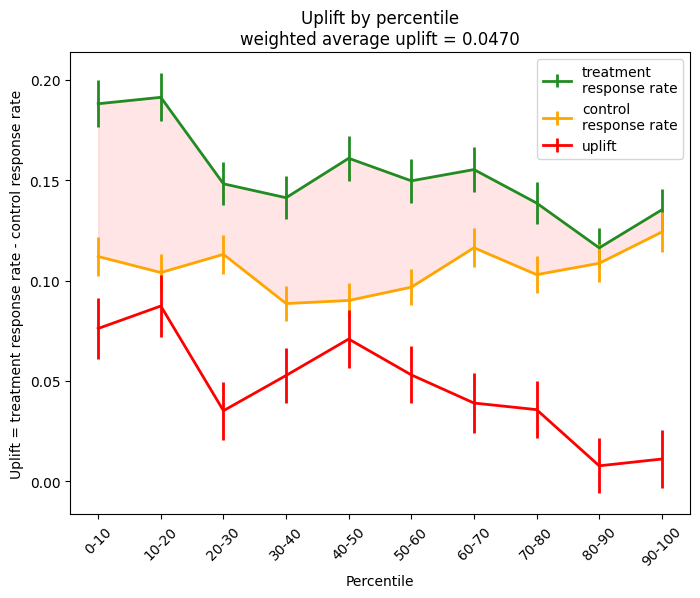

In [98]:
plot_uplift_by_percentile(y_true=y_val, uplift=uplift_predictions, treatment=treat_val, strategy='overall')

In [62]:
# 仿照sklift的uplift_by_percentile函数写法，获取k segment的predicted_uplift和actual uplift
def response_uplift_by_percentile(y_val, uplift_predictions, treat_val, group, bins=10):

  y_true, uplift, treatment = np.array(y_val), np.array(uplift_predictions), np.array(treat_val)
  order = np.argsort(uplift, kind='mergesort')[::-1]

  y_true_bin = np.array_split(y_true[order], bins)
  trmnt_bin = np.array_split(treatment[order], bins)
  uplift_bin = np.array_split(uplift[order], bins)

  trmnt_flag = 1 if group == 'treatment' else 0

  group_size = np.array([len(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
  response_rate = np.array([np.mean(y[trmnt == trmnt_flag]) for y, trmnt in zip(y_true_bin, trmnt_bin)])
  uplift_mean = np.array([np.mean(y[trmnt == trmnt_flag]) for y, trmnt in zip(uplift_bin, trmnt_bin)])

  return response_rate, uplift_mean, group_size


def uplift_by_deciles(y_val, uplift_predictions, treat_val, bins=10):

  y_val, uplift_predictions, treat_val = np.array(y_val), np.array(uplift_predictions), np.array(treat_val)

  response_rate_trmnt, uplift_mean_trmnt, n_trmnt = response_uplift_by_percentile(y_val, uplift_predictions, treat_val, group='treatment', bins=bins)
  response_rate_ctrl, uplift_mean_ctrl, n_ctrl = response_uplift_by_percentile(y_val, uplift_predictions, treat_val, group='control', bins=bins)

  actual_uplift_scores = response_rate_trmnt - response_rate_ctrl
  predicted_uplift_scores = (uplift_mean_trmnt * n_trmnt + uplift_mean_ctrl * n_ctrl) / (n_trmnt + n_ctrl)

  percentiles = [round(p * 100 / bins) for p in range(1, bins + 1)]

  percentiles = [f"0-{percentiles[0]}"] + [f"{percentiles[i]}-{percentiles[i + 1]}" for i in range(len(percentiles) - 1)]

  df = pd.DataFrame({
      'percentile': percentiles,
      'n_treatment': n_trmnt,
      'n_control': n_ctrl,
      'response_rate_treatment': response_rate_trmnt,
      'response_rate_control': response_rate_ctrl,
      'actual_uplift_scores': actual_uplift_scores,
      'uplift_mean_treatment': uplift_mean_trmnt,
      'uplift_mean_control': uplift_mean_ctrl,
      'predicted_uplift_scores': predicted_uplift_scores
  })

  return df

In [63]:
df = uplift_by_deciles(y_val, uplift_predictions, treat_val, bins=10)
df

,percentile,n_treatment,n_control,response_rate_treatment,response_rate_control,actual_uplift_scores,uplift_mean_treatment,uplift_mean_control,predicted_uplift_scores
0,0-10,1090,1045,0.188073,0.111962,0.076112,0.157363,0.156213,0.156800
1,10-20,1077,1058,0.191272,0.103970,0.087302,0.115678,0.115531,0.115605
2,20-30,1100,1035,0.148182,0.113043,0.035138,0.097651,0.097425,0.097542
3,30-40,1062,1073,0.141243,0.088537,0.052706,0.082871,0.082855,0.082863
4,40-50,1069,1066,0.160898,0.090056,0.070842,0.070008,0.070040,0.070024
5,50-60,1049,1086,0.149666,0.096685,0.052981,0.056937,0.056979,0.056958
6,60-70,1069,1066,0.155285,0.116323,0.038963,0.043558,0.043614,0.043586
7,70-80,1075,1059,0.138605,0.102927,0.035677,0.028570,0.028840,0.028704
8,80-90,1075,1059,0.116279,0.108593,0.007686,0.009297,0.009515,0.009405
9,90-100,1087,1047,0.135235,0.124164,0.011070,-0.032927,-0.032898,-0.032913


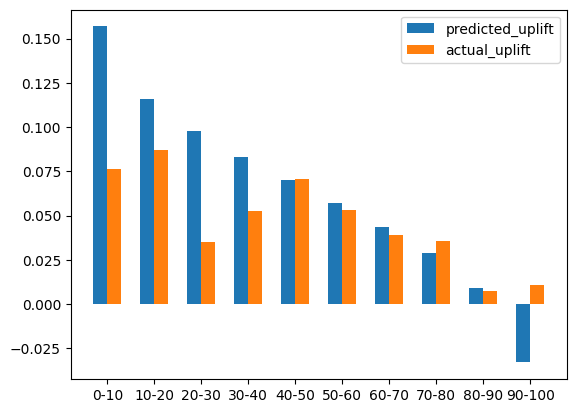

In [64]:
bar_width=0.3
x=np.arange(10)

tick_label= df['percentile']
plt.bar(x , df['predicted_uplift_scores'], bar_width, label='predicted_uplift')
plt.bar(x + bar_width, df['actual_uplift_scores'], bar_width, label='actual_uplift')

plt.legend()
plt.xticks(x+bar_width/2,tick_label)
plt.show()

## uplift curve and AUUC

0.022253775828709445


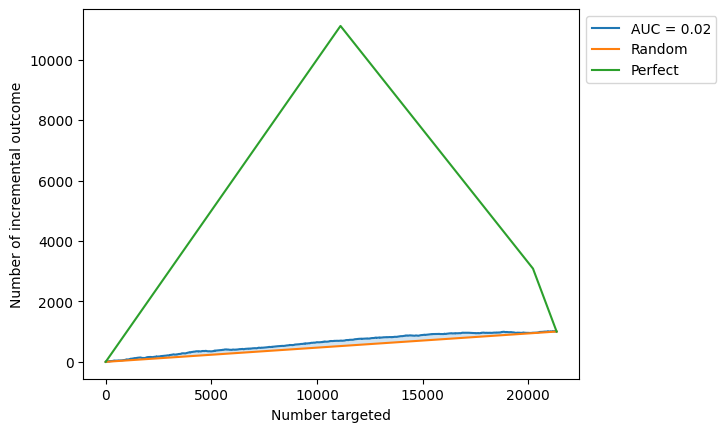

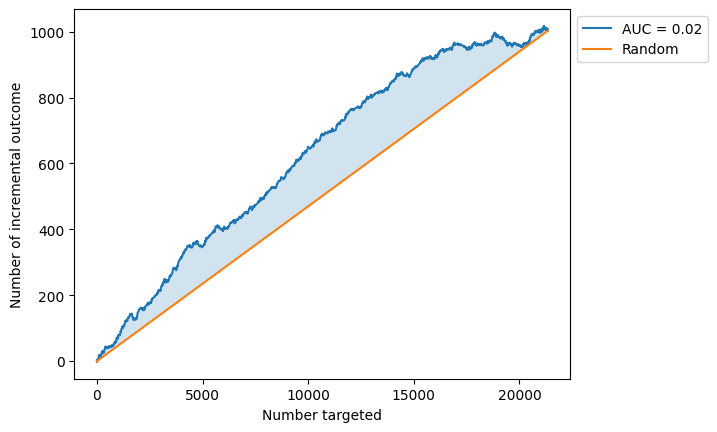

In [104]:
uplift_curve_score = uplift_curve(y_true=y_val, uplift=uplift_predictions, treatment=treat_val)
plot_uplift_curve(y_true=y_val, uplift=uplift_predictions, treatment=treat_val, perfect=True)
uplift_auc = uplift_auc_score(y_true=y_val, uplift=uplift_predictions, treatment=treat_val)
print(uplift_auc)
plot_uplift_curve(y_true=y_val, uplift=uplift_predictions, treatment=treat_val, perfect=False)

## Qini curve and Qini coefficient

0.048347813112264736


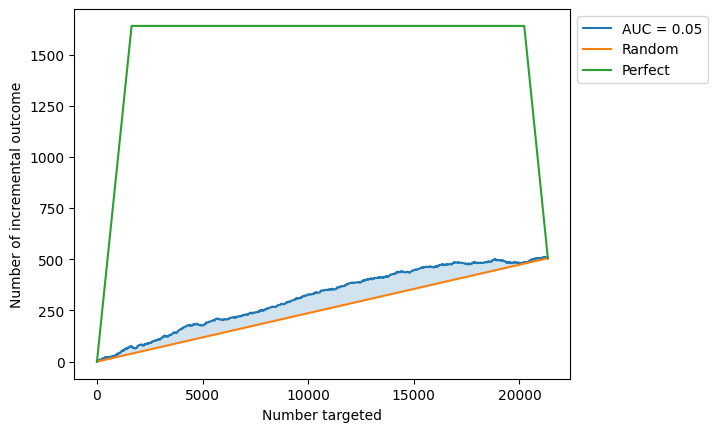

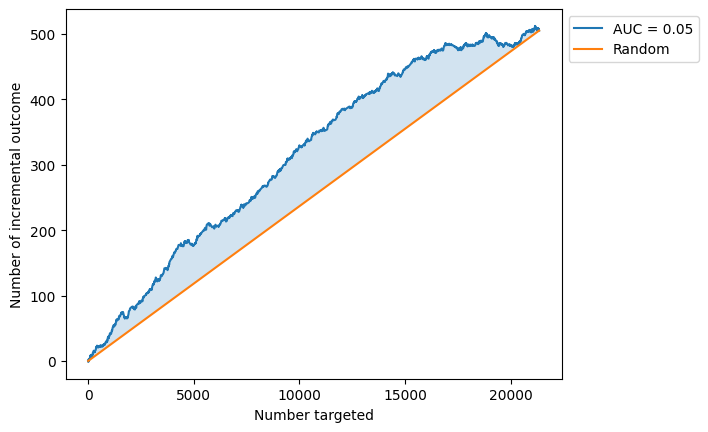

In [105]:
qini_curve_score = qini_curve(y_true=y_val, uplift=uplift_predictions, treatment=treat_val)
plot_qini_curve(y_true=y_val, uplift=uplift_predictions, treatment=treat_val, perfect=True)
qini_coef = qini_auc_score(y_true=y_val, uplift=uplift_predictions, treatment=treat_val)
print(qini_coef)
plot_qini_curve(y_true=y_val, uplift=uplift_predictions, treatment=treat_val, perfect=False)